In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve, average_precision_score,precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
dataset_dir = "/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images"
output_dir = "split_dataset"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Create train and test directories
for split_dir in [train_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Split ratio
test_size = 0.1  # 20% for testing

# Iterate through each class folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):  # Ensure it's a directory
        images = os.listdir(class_path)
        
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
        
        # Create class subdirectories in train and test folders
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        # Move files to respective folders
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("Dataset split completed successfully!")


Dataset split completed successfully!


In [8]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/split_dataset/train',
    target_size=(250, 250),
    batch_size= 16,
    class_mode = 'categorical'
)
test_datagen = ImageDataGenerator(
    rescale = 1./225
)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/split_dataset/test',
    target_size=(250, 250),
    batch_size=16,
    class_mode='categorical',
    shuffle=False 
)

model = Sequential([
    layers.Conv2D(32,(2,2),activation="relu",input_shape=(250, 250,3),padding="valid"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding="valid"),
    
    layers.Conv2D(64,(2,2),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(2,2),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(256,(2,2),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(512,(2,2),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(1024,(2,2),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(1024,activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(4,activation="softmax")
])
model.summary()
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("model_epoch_{epoch:02d}.keras",  # Save file as 'model_epoch_01.h5', 'model_epoch_02.h5', etc.
                             save_weights_only=False,  # Saves the entire model (architecture + weights)
                             save_freq='epoch',        # Save after every epoch
                             verbose=1)
history = model.fit(
    train_generator,
    epochs=11,
    validation_data=test_generator,
    callbacks=[early_stopping,checkpoint]
)

Found 39600 images belonging to 4 classes.
Found 4400 images belonging to 4 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 249, 249, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 249, 249, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 123, 123, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 123, 123, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 60, 60, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 29, 29, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 29, 29, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 13, 13, 512)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 13, 13, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 5, 5, 1024)          │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 5, 5, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 2, 2, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,663,588 (29.23 MB)

 Trainable params: 7,655,972 (29.21 MB)

 Non-trainable params: 7,616 (29.75 KB)

Epoch 1/11
2474/2475 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5076 - loss: 1.2638
Epoch 1: saving model to model_epoch_01.keras
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.5077 - loss: 1.2636 - val_accuracy: 0.6673 - val_loss: 0.8336
Epoch 2/11
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7265 - loss: 0.6622
Epoch 2: saving model to model_epoch_02.keras
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 70s 28ms/step - accuracy: 0.7265 - loss: 0.6622 - val_accuracy: 0.7775 - val_loss: 0.5702
Epoch 3/11
2473/2475 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8419 - loss: 0.4032
Epoch 3: saving model to model_epoch_03.keras
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 71s 29ms/step - accuracy: 0.8419 - loss: 0.4032 - val_accuracy: 0.8861 - val_loss: 0.2834
Epoch 4/11
2474/2475 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9074 - loss: 0.2452
Epoch 4: saving model to model_epoch_04.keras
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 71s 29ms/step - accuracy: 0.9074 - loss: 0.2452 - val_accuracy: 0.

2475/2475 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - accuracy: 0.9914 - loss: 0.0318
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9748 - loss: 0.0814
Train Accuracy: 0.9913
Validation Accuracy: 0.9566


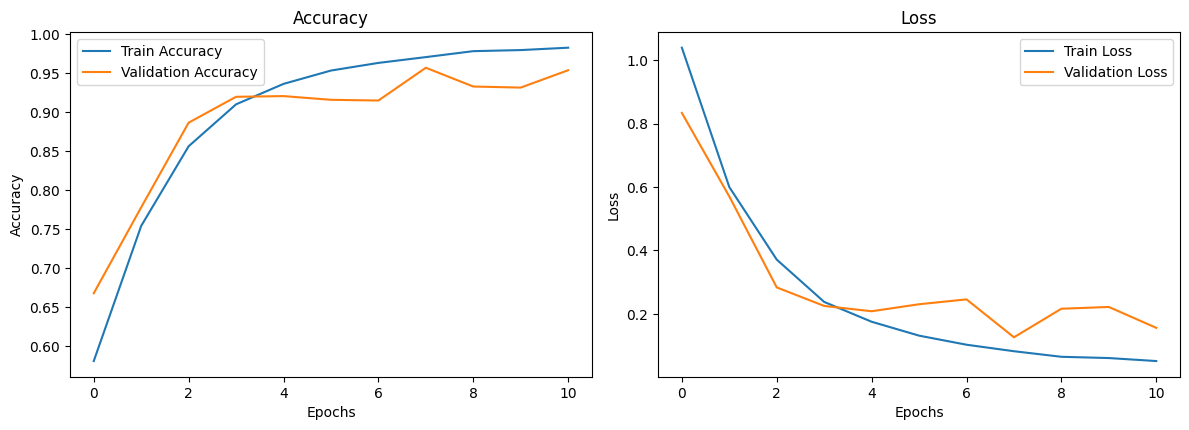

275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


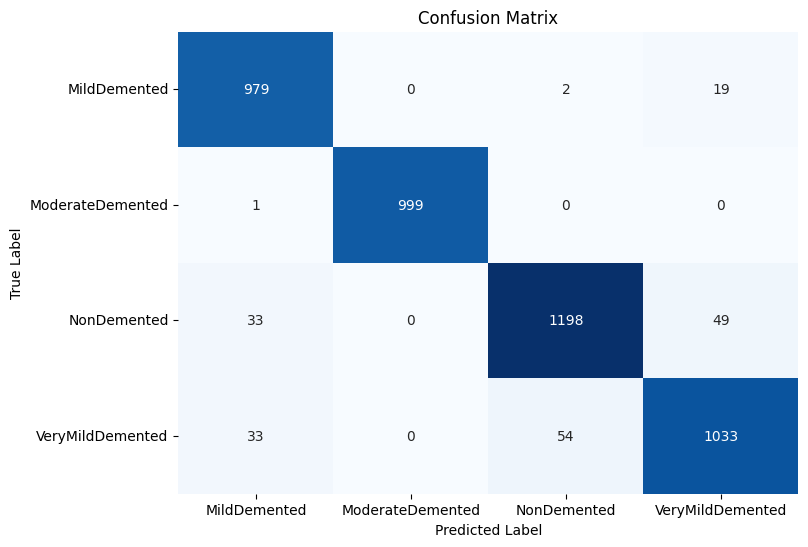

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.94      0.98      0.96      1000
ModerateDemented       1.00      1.00      1.00      1000
     NonDemented       0.96      0.94      0.95      1280
VeryMildDemented       0.94      0.92      0.93      1120

        accuracy                           0.96      4400
       macro avg       0.96      0.96      0.96      4400
    weighted avg       0.96      0.96      0.96      4400



In [10]:
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(test_generator)
print(f'Train Accuracy: {train_acc:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

# Save the model
model.save('alzeimers_multiclass.h5')

# Example usage of the prediction function
def predict_xray_image(model, img_path):
    img = image.load_img(img_path, target_size=(250, 250))  # Match size to model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)

    if prediction[0] > 0.5:
        result = 'Positive'
    else:
        result = 'Negative'

    plt.imshow(img)
    plt.title(f'Prediction: {result}')
    plt.show()

# Visualize metrics using Pandas and Matplotlib
history_df = pd.DataFrame(history.history)

# Plot multiple graphs (Accuracy and Loss)
plt.figure(figsize=(12, 8))

# Subplot for accuracy
plt.subplot(2, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(2, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate predictions for the test set
Y_pred = model.predict(test_generator)
Y_pred = np.argmax(Y_pred,axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, Y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(test_generator.classes, Y_pred, target_names=test_generator.class_indices.keys()))